In [1]:
nz=281; nx=1361
h=12.5
sig=0.48/(0.5/h)

fpeak=6.4
dt=0.0015
nt=4600

ntr=600

#How good initial model do you want?
siginit=200

#How many MPI processors do you order?
np=1

#How many OpenMP threads do you order?
nthreads=8

In [2]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def read(filename,n=None):
    if n==None:
        nn=(nx,nz)
    else:
        nn=n
    return np.fromfile(filename,dtype='float32').reshape(nn).T

tmppath=os.path.expanduser('~')+'/tmp'

def read_su(filename):
    !sustrip < $filename > $tmppath outpar=outpar
    data=read(tmppath,n=(ntr,nt))
    !rm $tmppath
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)


## Prepare

In [ ]:
##code
#!(cd ../../ ; git pull ; git checkout teaching ; make prepare)
#!(cd ../../FWD ; make cleanall ; make)
#!(cd ../../FWI ; make cleanall ; make)
#!gfortran smoothgauss2dfast_zhou.f90 -o smoothgauss2dfast_zhou

In [10]:
#clone model
#!wget https://s3.amazonaws.com/open.source.geoscience/open_data/elastic-marmousi/elastic-marmousi-model.tar.gz #https://wiki.seg.org/wiki/AGL_Elastic_Marmousi
!tar -xvzf elastic-marmousi-model.tar.gz
!(cd ./elastic-marmousi-model/model/ ; for fi in `ls *.tar.gz`; do tar -xvzf $$fi; done)
!segyread tape=./elastic-marmousi-model/model/MODEL_P-WAVE_VELOCITY_1.25m.segy | sustrip > vp.bin
!segyread tape=./elastic-marmousi-model/model/MODEL_DENSITY_1.25m.segy | sustrip | farith op=scale scale=1000 > rho.bin  #convert to [kg/m3]

elastic-marmousi-model/model/
elastic-marmousi-model/processed_data/SEGY-Time/Kirchhoff_PoSTM_time.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Time/SYNTHETIC_time.segy.tar.gz
elastic-marmousi-model/model/LAYER_PROPERTIES.pdf
elastic-marmousi-model/processed_data/SEGY-Depth/SYNTHETIC.segy.tar.gz
elastic-marmousi-model/processed_data/
elastic-marmousi-model/processed_data/SEGY-Depth/Kirchhoff_PreSDM.segy.tar.gz
elastic-marmousi-model/model/FINAL_HORIZONS.asc
elastic-marmousi-model/model/FINAL_HORIZONS_GX2.asc
elastic-marmousi-model/processed_data/SEGY-Depth/Kirchhoff_PoSDM.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Time/NMOstack_SRME_time.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Depth/Vs.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Depth/NMOstack.segy.tar.gz
elastic-marmousi-model/processed_data/SEGY-Depth/WE_PreSDM.segy.tar.gz
elastic-marmousi-model/reports/
elastic-marmousi-model/processed_data/SEGY-Time/
elastic-marmousi-model/model/MODEL

echo "Smooth Done!"
Smooth Done!
echo 'Resamp Done!'
Resamp Done!
make: 'topo' is up to date.
make: 'init' is up to date.
cat vp.12.5m rho.12.5m > true
cat vp.init            > init
echo 'Model Done!'
Model Done!
ximage < true n1=281 d1=12.5 d2=12.5 title=true wclip=1028 bclip=4700 cmap=hsv6 legend=1 &
ximage < init n1=281 d1=12.5 d2=12.5 title=init wclip=1028 bclip=4700 cmap=hsv6 legend=1 &


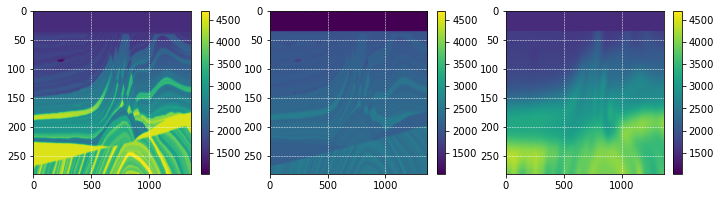

In [3]:
##smooth & resample the models
!make sig=$sig smooth resamp topo

##make initial model
!make siginit=$siginit init

##gathering
!make model

#plot
plt.figure(figsize=(12,3))
true=read('true',(2*nx,nz))
plt.subplot(1,3,1); imshow(true[:,:nx-1],clip=[1028,4700])
plt.subplot(1,3,2); imshow(true[:,nx:],clip=[1028,4700])
plt.subplot(1,3,3); imshow(read('init'),clip=[1028,4700])

## Observed data

In [5]:
!cp setup.in setup_fwd.in
!echo "DIR_OUT         './results_fwd' " >> setup_fwd.in
!echo "NS              1 " >> setup_fwd.in
!rm -r ./results_fwd
!export OMP_NUM_THREADS=$nthreads; ulimit -s unlimited; mpirun -np $np ../../exe/FWD setup_fwd.in > out_fwd

rm: cannot remove './results_fwd': No such file or directory
/bin/bash: line 1: module: No such file or directory


results_fwd/dsyn_Shot0001.su /home/wzhou/tmp


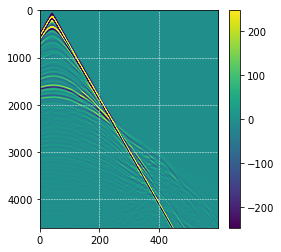

In [44]:
plt.figure(figsize=(4,4))
imshow(read_su('results_fwd/dsyn_Shot0001.su'),perc=98)

## FWI gradient

In [6]:
#ishot=1
ishot="'1:10:80'"
#ishot='1:20:144'

!cp setup.in setup_grad.in
!echo "DIR_OUT            './results_grad' " >> setup_grad.in
!echo "FILE_MODEL         init" >> setup_grad.in
!echo "MODEL_ATTRIBUTES   vp" >> setup_grad.in
!echo "ISHOT              $ishot"  >> setup_grad.in
!rm -r ./results_grad
!export OMP_NUM_THREADS=$nthreads; ulimit -s unlimited; mpirun -np $np ../../exe/FWI setup_grad.in > out_grad

/bin/bash: line 1: module: No such file or directory


results_fwd/dsyn_Shot0001.su /home/wzhou/tmp
results_grad/dsyn_Shot0001.su /home/wzhou/tmp
results_grad/dadj_Shot0001.su /home/wzhou/tmp


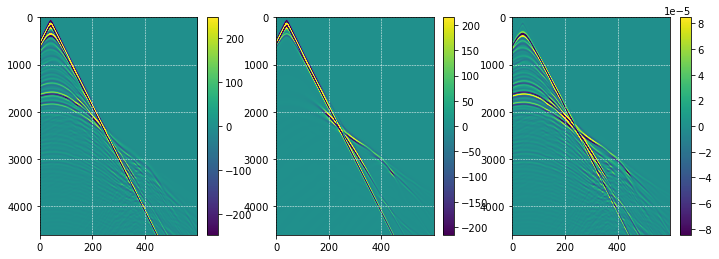

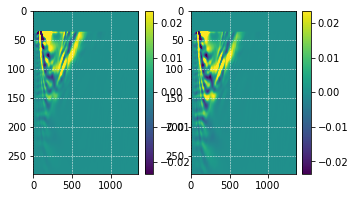

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su('results_fwd/dsyn_Shot0001.su'),perc=98)
plt.subplot(1,3,2); imshow(read_su('results_grad/dsyn_Shot0001.su'),perc=98)
plt.subplot(1,3,3); imshow(read_su('results_grad/dadj_Shot0001.su'),perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('results_grad/qp0%g'),perc=98)
plt.subplot(1,2,2); imshow(read('results_grad/qp0%pg'),perc=98)

## FWI iterations

In [ ]:
ishot=1
#ishot=1:10:80
#ishot=1:20:144

!cp setup.in setup_fwi.in
!echo "DIR_OUT            './results_fwi' " >> setup_fwi.in
!echo "FILE_MODEL         init" >> setup_fwi.in
!echo "MODEL_ATTRIBUTES   vp" >> setup_fwi.in
!echo "ISHOT              '$(ishot)' " >> setup_fwi.in
!echo "SMOOTHING          Laplacian  " >> setup_fwi.in
!echo "JOB                optimization " >> setup_fwi.in
!rm -r ./results_fwi
!export OMP_NUM_THREADS=$(nthreads); ulimit -s unlimited; mpirun -np $(np) ../../exe/FWI setup_fwi.in > out_fwi

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su('results_fwd/dsyn_Shot0001.su'),perc=98)
plt.subplot(1,3,2); imshow(read_su('results_fwi/dsyn_Shot0001.su'),perc=98)
plt.subplot(1,3,3); imshow(read_su('results_fwi/dadj_Shot0001.su'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read('init'),clip=[1028,4700])
plt.subplot(1,3,2); imshow(read('results_fwi/model_final'),clip=[1028,4700])
plt.subplot(1,3,3); imshow(read('true')[:,:nx-1],clip=[1028,4700])